In [1]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import torchvision.models as models



In [2]:
filepath='/content/drive/MyDrive/objectdetection/'

In [3]:
annotation_path=filepath+'annotations.csv'
annotation=pd.read_csv(annotation_path,header=None)

In [4]:
annotation.head(5)

0    1    2    3    4    5
0  d33229162d822801_jpg.rf.0098eaffc64d4c92e89076...  143  151  358  333  Car
1  d33229162d822801_jpg.rf.0098eaffc64d4c92e89076...    0  154   29  190  Car
2  d33229162d822801_jpg.rf.0098eaffc64d4c92e89076...   26  157   55  188  Car
3  d33229162d822801_jpg.rf.0098eaffc64d4c92e89076...   48  159   80  189  Car
4  d33229162d822801_jpg.rf.0098eaffc64d4c92e89076...   61  163   97  185  Car

In [6]:
def cvt(x):
  return int((x/416)*800)

objects_location={}
class_id = {}
class_index = 0
images=[]
for i in annotation.index:
  imagename,x1,y1,x2,y2,clas=[annotation[j].iloc[i] for j in range (6)]
  if(imagename not in images):
    images.append(imagename)
    objects_location[imagename]=[]
  
  if(clas not in class_id):
    class_id[clas] = class_index
    class_index+=1

  objects_location[imagename].append([ cvt(x1),cvt(y1),cvt(x2),cvt(y2),class_id[clas] ])
  
print(class_id)
id_class = { v:k for k,v in class_id.items()}

{'Car': 0, 'Ambulance': 1, 'Motorcycle': 2, 'Bus': 3, 'Truck': 4}


In [7]:
from google.colab.patches import cv2_imshow


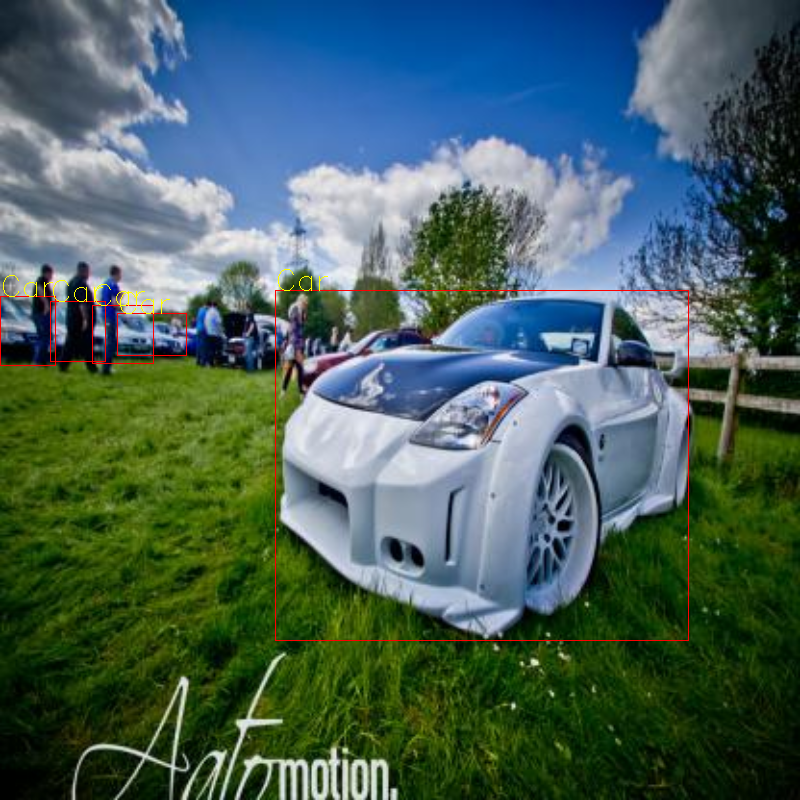

In [8]:
img=images[0]

image=cv2.imread(filepath+img)
image=cv2.resize(image,(800,800))

for i in objects_location[img]:
  image=cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,0,255), 1)
  image=cv2.putText(image,id_class[i[-1]], (i[0],i[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,255))
  
cv2_imshow(image)



**Anchors**



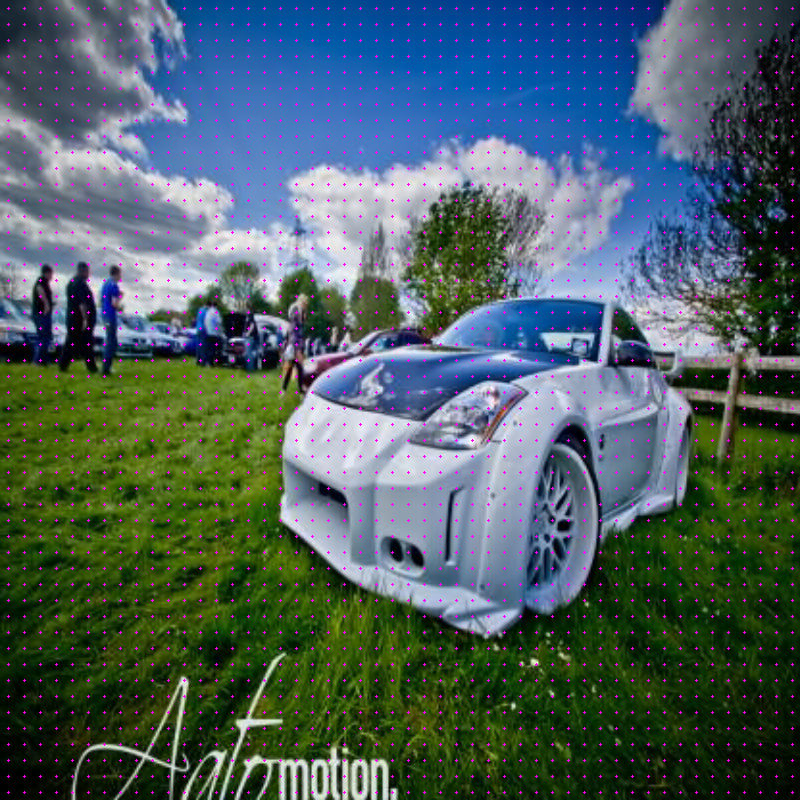

In [9]:
image=cv2.imread(filepath+img)
im_size = 800
anchors_size = 16

image=cv2.resize(image,(im_size,im_size))

x_anch=np.arange(anchors_size//2,im_size+anchors_size//2,anchors_size)
y_anch=np.arange(anchors_size//2,im_size+anchors_size//2,anchors_size)

AnchorCenters = []


for y in y_anch:
  for x in x_anch:

    AnchorCenters.append((x,y))
    image=cv2.circle(image, (x,y), radius=1, color=(255, 0, 255), thickness=-1)

cv2_imshow(image)    

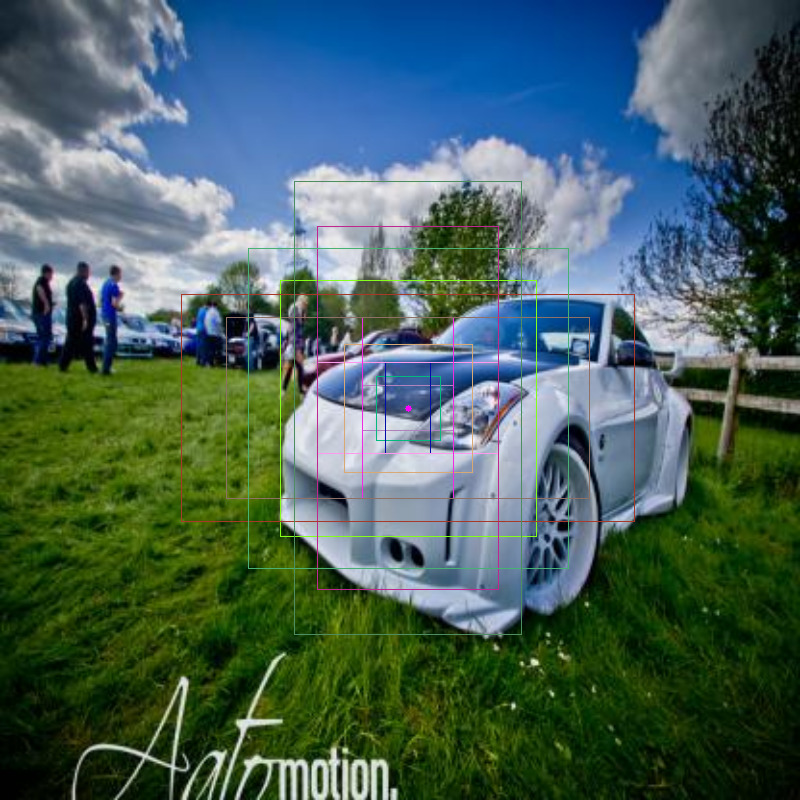

In [10]:

AnchorBoxes=[]
Anchor_scales=[4,8,16,20]
Anchor_ratios=[0.5, 1, 2]

image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))



import random

for i,Ac in enumerate(AnchorCenters):
  for S in Anchor_scales:
    for R in Anchor_ratios:

      H=anchors_size*S*np.sqrt(R)
      W=anchors_size*S*np.sqrt(1/R)

      x1=int(Ac[0]-W/2)
      y1=int(Ac[1]-H/2)
      x2=int(Ac[0]+W/2)
      y2=int(Ac[1]+H/2)

      AnchorBoxes.append([x1,y1,x2,y2])
      if(i==1275):
          image=cv2.rectangle(image, (x1,y1), (x2,y2), (random.randint(0,255),random.randint(0,255),random.randint(0,255)), 1)
          image=cv2.circle(image,(Ac[0],Ac[1]),3,(255,0,255),-1)
cv2_imshow(image)          


In [11]:
Anchor_box=np.array((AnchorBoxes))
valid_anchor_index=np.where((Anchor_box[:,0]>=0)&(Anchor_box[:,1]>=0)&(Anchor_box[:,2]<=im_size)&(Anchor_box[:,3]<=im_size))[0]
print(Anchor_box.shape,valid_anchor_index.shape)
Anchor_boxes = Anchor_box[valid_anchor_index]

(30000, 4) (17216,)


In [12]:
def iou_area(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / (float(boxAArea + boxBArea - interArea) + 0.00000001)
	# return the intersection over union value
	return iou

In [13]:
def call(reg_pred_pos,Anchor_boxes_pos):


    

      


      width = Anchor_boxes_pos[:,2] - Anchor_boxes_pos[:,0]
      height = Anchor_boxes_pos[:,3] - Anchor_boxes_pos[:,1]
      ctr_x =  Anchor_boxes_pos[:,0] + width*0.5
      ctr_y =  Anchor_boxes_pos[:,1] + height*0.5

      
      dx = reg_pred_pos[:,0]
      dy = reg_pred_pos[:,1]
      dw = reg_pred_pos[:,2]
      dh = reg_pred_pos[:,3]
      
      

      
      O_ctr_x = dx * width + ctr_x
      O_ctr_y = dy * height + ctr_y 
      O_height = np.exp(dh) * height 
      O_width = np.exp(dw) * width

      

      return np.stack([O_ctr_x - O_width/2 ,O_ctr_y - O_height/2 ,O_width,O_height],axis=1).astype(int)

[[34, 163, 757, 742, 1], [578, 265, 794, 536, 1]]
[[ 34 163 723 579]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]
 [578 265 216 271]] [5134 7673 7674 7682 7690 8123 8124 8132 8140 8564 8573 8574 8582 8590
 9014 9023 9024 9032 9040 9464 9473 9474 9482 9490 9923 9924 9932 9940]


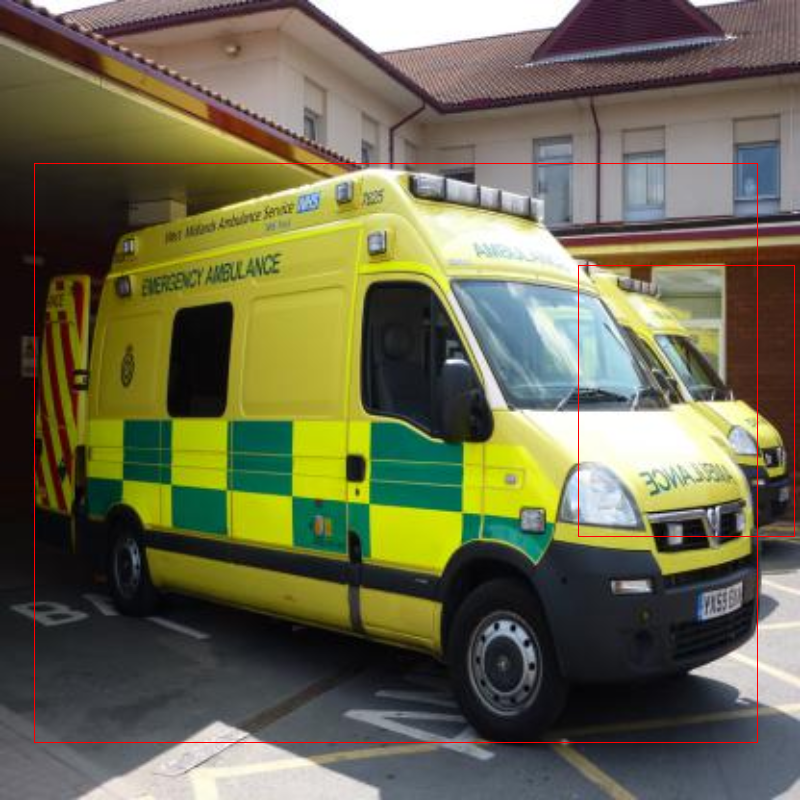

In [45]:
image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))


def BBoxPropotion_format(anchor_max_iou_object,Anchor_boxes):

  width = Anchor_boxes[:,2] - Anchor_boxes[:,0]
  height = Anchor_boxes[:,3] - Anchor_boxes[:,1]
  ctr_x =  Anchor_boxes[:,0] + width*0.5
  ctr_y =  Anchor_boxes[:,1] + height*0.5

  O_width = anchor_max_iou_object[:,2] - anchor_max_iou_object[:,0]
  O_height = anchor_max_iou_object[:,3] - anchor_max_iou_object[:,1]
  O_ctr_x =  anchor_max_iou_object[:,0] + O_width*0.5
  O_ctr_y =  anchor_max_iou_object[:,1] + O_height*0.5

  eps = np.finfo(np.float32).eps
  height = np.maximum(height, eps) 
  width = np.maximum(width, eps)

  
  dx = (O_ctr_x - ctr_x) / width
  dy = (O_ctr_y - ctr_y) / height
  dh = np.log(O_height / height)
  dw = np.log(O_width / width)


  return np.stack([dx,dy,dw,dh],axis=1)


  


def GetAnchorIOU(ObjectLocations,Anchor_boxes):
  # ObjectLocations : object locations in an image
  # Default valid anchors for 800 px image with 16px interval

  IouLabels = np.ones(( len(Anchor_boxes) ))*-1
  IouValues = np.empty( (len(ObjectLocations),len(Anchor_boxes)),dtype=np.float32)

  for obj_id,obj in enumerate(ObjectLocations):
    for A_id,A in enumerate(Anchor_boxes): # valid

      IouValues[obj_id,A_id] = iou_area(obj[:-1],A)

  

  anchor_max_iou = np.max(IouValues,axis=0)
  n_pos = min((anchor_max_iou>0.62).sum(),128)
  neg_index = np.where(anchor_max_iou<0.3)[0]
  neg_samples = np.random.choice(neg_index, size=(n_pos+len(ObjectLocations))*3, replace=False)
  IouLabels[neg_samples] = 0
  
  
  pos_index = np.where(anchor_max_iou>0.62)[0]
  pos_samples = np.random.choice(pos_index, size=n_pos, replace=False)
  IouLabels[pos_samples] = 1

  gt_max_iou = np.argmax(IouValues,axis=1)
  IouLabels[gt_max_iou] = 1

  anchor_max_iou = np.argmax(IouValues,axis=0)
  anchor_max_iou_object = np.array(ObjectLocations)[anchor_max_iou]

  pred_gt_cls = anchor_max_iou_object[:,-1]
  pred_gt_reg = BBoxPropotion_format(anchor_max_iou_object[:,:-1],Anchor_boxes)


  
  return [torch.tensor(IouLabels) , torch.tensor(pred_gt_reg), torch.tensor(pred_gt_cls)]

  #return [IouLabels , pred_gt_reg, pred_gt_cls]


      

Targets = GetAnchorIOU(objects_location[img],Anchor_boxes)
print(objects_location[img])
[IouLabels , pred_gt_reg, pred_gt_cls] = Targets

pos_anchors = np.where(IouLabels==1)[0]

coordinates = call(pred_gt_reg[pos_anchors],Anchor_boxes[pos_anchors])

image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))

print(coordinates,pos_anchors)

for c in coordinates:

  image=cv2.rectangle(image, (c[0],c[1]), (c[0]+c[2],c[1]+c[3]), (0,0,255), 1)
cv2_imshow(image)




In [15]:

import torchvision
import torch.nn.functional as F
from torch.nn import Conv2d,BatchNorm2d

In [16]:
image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))

class RPN(torch.nn.Module):

  def __init__(self, n_anchor):

    super().__init__()

    self.backbone = torchvision.models.vgg16(pretrained=True)
    modules = list(self.backbone.features[:30]) 
    Dimension = modules[-2].out_channels
    self.backbone = torch.nn.Sequential(*modules)

    self.refine = Conv2d(Dimension,Dimension*4,3,1,1)

    self.reg_head = Conv2d(Dimension*4, n_anchor*4 ,1,1,0)
    self.cls_head = Conv2d(Dimension*4, n_anchor*2 ,1,1,0)

    self.n_anchor = n_anchor

    




  def PostProcess(self,predictions,valid_anchor_index,return_numpy=False):
    [reg_pred,cls_pred] = predictions

    reg_pred = torch.permute(reg_pred,(1,2,0)).contiguous().view(-1,self.n_anchor,4).view(-1,4)
    cls_pred = torch.permute(cls_pred,(1,2,0)).contiguous().view(-1,self.n_anchor,2).view(-1,2)

    reg_pred = reg_pred[valid_anchor_index]
    cls_pred = cls_pred[valid_anchor_index]


    #print(reg_pred.shape,cls_pred.shape,valid_anchor_index.shape)

    if(return_numpy):
      return[reg_pred.cpu().data.numpy(),cls_pred.cpu().data.numpy()]
    else:
      return [reg_pred,cls_pred]

  def ComputeLoss(self,predictions,targets):

    [reg_pred,cls_pred] = predictions

    [anc_label,reg_tar] = targets

    valid_anchors = anc_label >=0 # Anchors which contribute to objectness class
    loss_cls = self.classification_loss(cls_pred[valid_anchors],anc_label[valid_anchors])

    pos_anchors = anc_label > 0
    pos_anchors = pos_anchors.unsqueeze(-1)
    #print(pos_anchors.shape,reg_pred.shape,reg_tar.shape)
    pos_anchors = pos_anchors.expand_as(reg_pred)
    
    valid_reg_pred = reg_pred[pos_anchors].view(-1,4)
    valid_reg_tar = reg_tar[pos_anchors].view(-1,4)
    #print(valid_reg_pred.shape,reg_pred.shape)
    loss_reg = self.regression_loss(valid_reg_pred,valid_reg_tar)
    #print(loss_cls,loss_reg)
    return loss_cls+loss_reg






  def classification_loss(self,prediction,target):
    
    loss=F.cross_entropy(prediction, target.long(), ignore_index = -1)
    return loss

  def regression_loss(self,prediction,target):

    loss =F.l1_loss(target , prediction)
    return loss  

  def forward(self,input_image):

    y = self.backbone(input_image)

    y = self.refine(y)

    reg_pred = self.reg_head(y)
    cls_pred = self.cls_head(y)

    return [reg_pred,cls_pred]

   

    
  def loss(self,prediction,target):
    cls,reg=prediction
    anc_lab,anc_bbbox=target

    cls_scores=cls.permute(0,2,3,1).contiguous().view(1,-1,2)
    reg_scores=reg.permute(0,2,3,1).contiguous().view(1,-1,4)

    cls_scores=torch.squeeze(cls_scores,0)
    reg_scores=torch.squeeze(reg_scores,0)


    pos_lab=anc_lab>0
    pos_lab=pos_lab.expand_as(reg_scores)
    loc_pred=reg_scores[pos_lab].view(-1,4)
    loc_tar=anc_bbbox[pos_lab].view(-1,4)
    print(loc_pred.shape,loc_tar.shape)
    print(cls_scores.shape,anc_lab.shape)
    print(len(torch.where(anc_lab==1)[0]))

    cls_loss=self.classification_loss(cls_scores,anc_lab)
    reg_loss=self.regression_loss(loc_pred,loc_tar)

    
model = RPN(len(Anchor_ratios)*len(Anchor_scales))




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
device = 'cuda'
model = model.to(torch.device(device))
model_path = "/content/drive/MyDrive/RPN.pth"

model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))  
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])


"""image_tensor = transform(image)

for i in range(len(Targets)):
  Targets[i] = torch.tensor(Targets[i])


op = model(image_tensor)
op = model.PostProcess(op,valid_anchor_index)
loss = model.ComputeLoss(op,Targets[:2])
print(loss)"""
from torch.optim import Adam
from tqdm import tqdm
optimizer = Adam(model.parameters(),lr=0.0001,weight_decay=1e-5)

for epc in range(500):

  total_loss=[]
  t=tqdm(images,total=len(images))

  for img in t:

    Targets = GetAnchorIOU(objects_location[img],Anchor_boxes)
    for i in range(3):
      Targets[i] = Targets[i].to(torch.device(device))
    image=cv2.imread(filepath+img)
    image=cv2.resize(image,(im_size,im_size))

    image_tensor = transform(image)
    image_tensor = image_tensor.to(torch.device(device))

    
    optimizer.zero_grad()

    op = model(image_tensor)
    op = model.PostProcess(op,valid_anchor_index)
    loss = model.ComputeLoss(op,Targets[:2])

    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    string="epoch  "+str(epc)+"   loss: {:.4f}".format(sum(total_loss)/len(total_loss))
    t.set_description(string)
    t.refresh() 
  torch.save(model.state_dict(),model_path)

epoch  18   loss: 0.0816:  18%|█▊        | 80/439 [00:39<02:49,  2.11it/s]

In [37]:
img = images[3]

In [38]:
from torchvision import transforms

model_path = "/content/drive/MyDrive/RPN.pth"
model = model.to(torch.device('cpu'))

model.load_state_dict(torch.load(model_path , map_location=torch.device('cpu')))  

transform = transforms.Compose([transforms.ToTensor()])


#Targets = GetAnchorIOU(objects_location[img],Anchor_boxes)


In [39]:
image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))

image_tensor = transform(image)

outputs = model(image_tensor)
[reg_pred,cls_pred] = model.PostProcess(outputs,valid_anchor_index,return_numpy=True)
Targets = GetAnchorIOU(objects_location[img],Anchor_boxes)


In [48]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1,keepdims=True)
class RPN2ROI():
  def __init__(self):
    pass

  def NMS(self,Bounding_boxes,Scores):
    
    object_order = np.argsort(Scores).tolist()
    final_objects = []
    while(len(object_order)):
      curr_obj = Bounding_boxes[object_order[-1]]
      final_objects.append(object_order[-1])
      object_order.pop()

      for i in range(len(object_order)-1,-1,-1):
        #print(iou_area(Bounding_boxes[object_order[i]],curr_obj))
        if(iou_area(Bounding_boxes[object_order[i]],curr_obj)>0.3):
          
          object_order.pop(i)
      





    return np.array(final_objects)
  def __call__(self,rpn_pred_reg,rpn_pred_cls,Anchor_boxes,Targets):

      # Targets are indexed based on valid predicted anchors(having more objectnes score) and fed to faster rcnn part for its training


      rpn_pred_cls = softmax(rpn_pred_cls)
      pos_anchors =np.where(  (np.argmax(rpn_pred_cls,axis=1)==1)  &  (np.max(rpn_pred_cls,axis=1)>0.8) )[0] 
      

      reg_pred_pos = rpn_pred_reg[pos_anchors]
      score_pred_pos = rpn_pred_cls[pos_anchors]
      Anchor_boxes_pos = Anchor_boxes[pos_anchors]

      for i in range(len(Targets)):
        Targets[i] = Targets[i][pos_anchors]


      


      width = Anchor_boxes_pos[:,2] - Anchor_boxes_pos[:,0]
      height = Anchor_boxes_pos[:,3] - Anchor_boxes_pos[:,1]
      ctr_x =  Anchor_boxes_pos[:,0] + width*0.5
      ctr_y =  Anchor_boxes_pos[:,1] + height*0.5

      
      dx = reg_pred_pos[:,0]
      dy = reg_pred_pos[:,1]
      dw = reg_pred_pos[:,2]
      dh = reg_pred_pos[:,3]
      
      O_ctr_y = dy *height + ctr_y 
      O_ctr_x = dx * width + ctr_x
      O_height = np.exp(dh) * height 
      O_width = np.exp(dw) * width

      return np.stack([O_ctr_x - O_width/2 ,O_ctr_y - O_height/2 ,O_ctr_x + O_width/2 ,O_ctr_y + O_height/2],axis=1) ,np.max(score_pred_pos,axis=1),Targets







(55, 4)


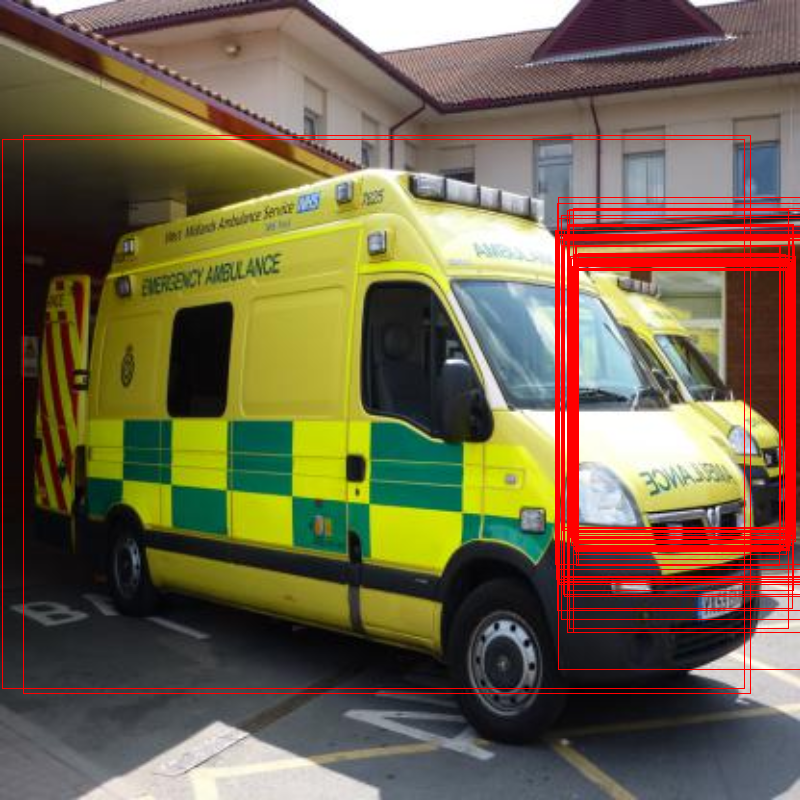

AFTER NMS
[37  1]


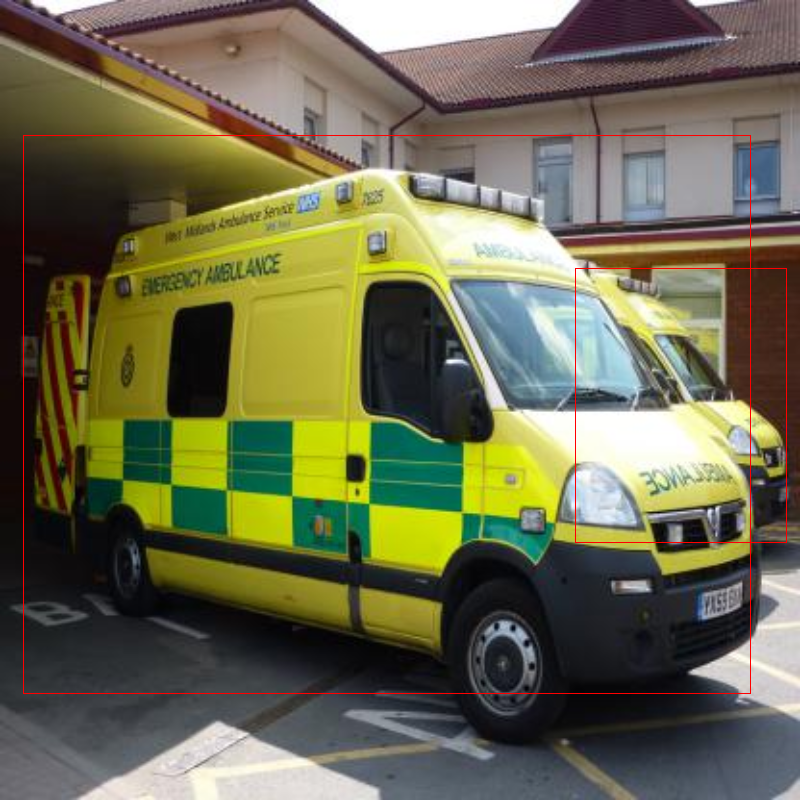

In [49]:
Targets = GetAnchorIOU(objects_location[img],Anchor_boxes)

Pooling = RPN2ROI()
coordinates , scores , Targets_positive= Pooling(reg_pred,cls_pred,Anchor_boxes,Targets[1:])

image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))

print(coordinates.shape)

for c in coordinates.astype(int):

  image=cv2.rectangle(image, (c[0],c[1]), (c[2],c[3]), (0,0,255), 1)
cv2_imshow(image)

print("AFTER NMS")

nms_coordinates = Pooling.NMS(coordinates , scores)
print(nms_coordinates)

image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))


for c in coordinates[nms_coordinates].astype(int):

  image=cv2.rectangle(image, (c[0],c[1]), (c[2],c[3]), (0,0,255), 1)
cv2_imshow(image)




In [50]:
pooling_coordinates = np.divide(coordinates[nms_coordinates],anchors_size).astype(np.int64)
pooling_Targets = [ Targets_positive[0][nms_coordinates] , Targets_positive[1][nms_coordinates] ]
print(pooling_coordinates.shape,type(pooling_Targets[1]))


(2, 4) <class 'torch.Tensor'>


In [51]:
pooling_coordinates = torch.tensor(pooling_coordinates)
pooling_Targets = [ torch.tensor(pooling_Targets[0]) , torch.tensor(pooling_Targets[1]) ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [54]:
from torch.nn import AdaptiveMaxPool2d

class FasterRCNN(torch.nn.Module):

  def __init__(self, pool_shape):

    super().__init__()

    self.backbone = torchvision.models.vgg16(pretrained=True)
    modules = list(self.backbone.features[:30]) 
    Dimension = modules[-2].out_channels
    self.backbone = torch.nn.Sequential(*modules)

    self.roipool  = AdaptiveMaxPool2d(pool_shape[0], pool_shape[1])
  def Pooling(self,feature,pooling_coordinates):
    print(feature.shape,pooling_coordinates.shape)
    roi_imgs = []
    for roi in pooling_coordinates:
      pool_img = feature[...,roi[1]:roi[3],roi[0]:roi[2]]
      pool_img = self.roipool(pool_img)[0]
      roi_imgs.append(pool_img)
    return torch.stack(roi_imgs,0)
    

  def forward(self,image_tensor,pooling_coordinates):

     y = self.backbone(image_tensor)
     roi_pooled_feats = self.Pooling(y,pooling_coordinates)


detector =  FasterRCNN((7,7))
detector(image_tensor,pooling_coordinates)

  

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([512, 50, 50]) torch.Size([2, 4])
torch.Size([512, 7, 7])
torch.Size([512, 7, 7])


In [ ]:
image=cv2.imread(filepath+img)
image=cv2.resize(image,(im_size,im_size))

image_tensor = transform(image)

for i in range(len(Targets)):
  Targets[i] = torch.tensor(Targets[i])


op = model(image_tensor,pooling_coordinates,anchors_size)
loss = model.ComputeLoss(op,pooling_Targets)
print(loss)

In [ ]:
anchors_size

16

In [ ]:
image=cv2.imread(filepath+img)
image=cv2.resize(image,(800,800))

image=torch.tensor(image,dtype=torch.float).permute(2,0,1)
image=image.unsqueeze(0)
region_propasal=RPN()

pred=region_propasal(image)
loss=region_propasal.loss(pred,[torch.tensor(Anchor_labels),torch.tensor(Anchor_location)])


TypeError: ignored

In [ ]:
print(Anchor_location.shape)
print(Anchor_labels.shape)

In [ ]:
dummy=torch.ones((87500, 4))

In [ ]:
Anchor_labels=torch.tensor(Anchor_labels)
pos_lab=torch.where(Anchor_labels>0)
print(pos_lab)


In [ ]:
tst=torch.tensor([True,True,False,True,False]).view(-1,1)
dummy=torch.ones((5,5))
tst=tst.expand_as(dummy)
print(tst)

In [ ]:
x=anchor_ious[:,0]>0.65
for i,j in zip(x,anchor_ious[:,0]):
  print(i,j)

In [ ]:
iou_area( [71, 111, 763, 750, 'Car'],[541, 234, 722, 325])

In [ ]:
# List all the layers of VGG16
model = torchvision.models.resnet50(pretrained=True)
fe = list(model.features)
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 

req_features = []
k = dummy_img.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//32:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()
print(len(req_features)) #30
print(out_channels) # 512